In [1]:
!pip install neuralforecast pandas==2.2.1

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import torch

# 创建数据库引擎
database_url = "sqlite:////content/data.sqlite"
engine = create_engine(database_url)

# define hyper paras
use_standard_scaler = True
save_imputed_data = False
notebook_mode = 'train'
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

model_name = 'Autoformer'
model_version = '1.0.0'
saved_table = 'sh_customs_daily_pred'

In [3]:
query = "select date as ds,global_entry,hkmo_entry,tw_entry from sh_customs_daily_imputed"
data = pd.read_sql_query(query, engine)
original_data = data.copy()

In [4]:
# melting,转换为长格式
df_long = pd.melt(data, id_vars=['ds'], var_name='unique_id', value_name='y')
df_long['ds'] = pd.to_datetime(df_long.ds)

## 使用cross validation选择模型

使用RTX 4070Ti GPU 训练3小时

In [5]:
import os

# 防止gpu内存不足中断训练
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [6]:
import pandas as pd

from neuralforecast.core import NeuralForecast
from neuralforecast.models import Informer, Autoformer, FEDformer, PatchTST


horizon = 30
models = [
         Informer(h=3*horizon,                 # Forecasting horizon
                input_size=6*horizon,           # Input size
                n_head=8,
                scaler_type='minmax1',
                learning_rate=1e-3,
                max_steps=2000,
                val_check_steps=200,
                windows_batch_size=128,
                early_stop_patience_steps=3,
                random_seed=42), # Stop training if validation loss does not improve
          Autoformer(h=3*horizon,
                     n_head=8,
                input_size=6*horizon,
                     scaler_type='minmax1',
                learning_rate=1e-3,
                max_steps=2000,
                val_check_steps=200,
                windows_batch_size=128,
                early_stop_patience_steps=3,
                     random_seed=42),
          PatchTST(h=3*horizon,
                input_size=6*horizon,
                   scaler_type='minmax1',
                learning_rate=1e-3,
                max_steps=2000,
                val_check_steps=200,
                windows_batch_size=128,
                   revin=True,
                   revin_affine=True,
                early_stop_patience_steps=3,
                   random_seed=42),
         ]

nf = NeuralForecast(
    models=models,
    freq='1D',
)
cross_val = nf.cross_validation(df_long, val_size=int(0.1*len(df_long)), test_size=int(0.1*len(df_long)),n_windows=None)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:lightning_fabric.utilities.seed:Seed set to 42


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

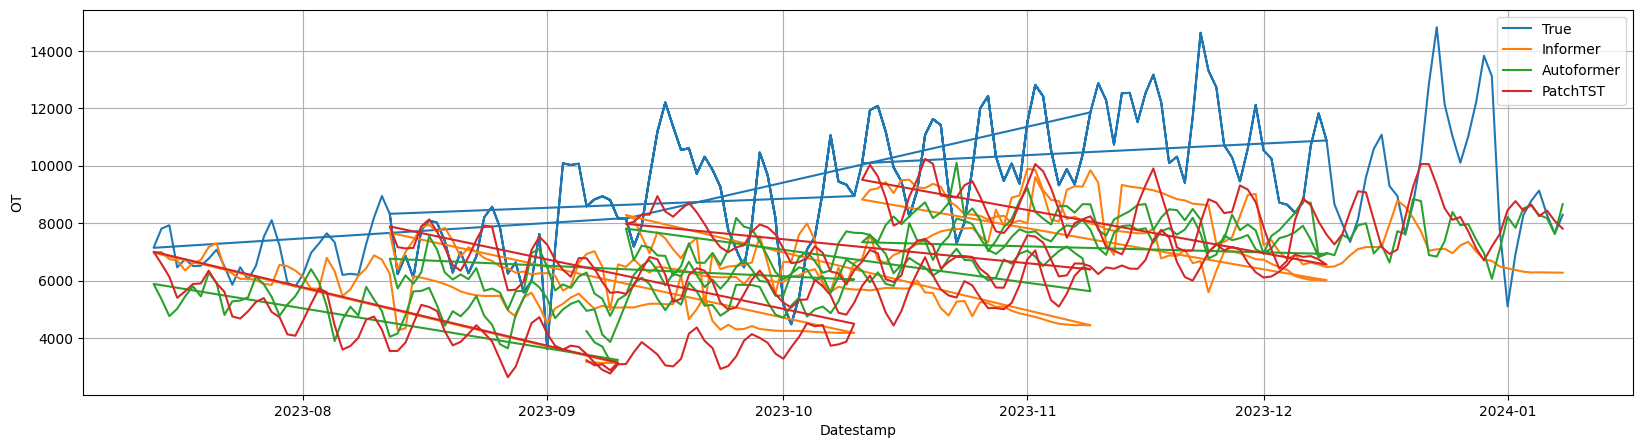

In [15]:
from matplotlib import pyplot as plt

Y_plot = cross_val[cross_val['unique_id']=='global_entry']
cutoffs = cross_val['cutoff'].unique()[::horizon]
Y_plot = Y_plot[cross_val['cutoff'].isin(cutoffs)]
Y_plot = Y_plot[-365:]

plt.figure(figsize=(20,5))
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['Informer'], label='Informer')
plt.plot(Y_plot['ds'], Y_plot['Autoformer'], label='Autoformer')
plt.plot(Y_plot['ds'], Y_plot['PatchTST'], label='PatchTST')
plt.xlabel('Datestamp')
plt.ylabel('OT')
plt.grid()
plt.legend()


In [8]:
from neuralforecast.losses.numpy import mae

mae_informer = mae(cross_val['y'], cross_val['Informer'])
mae_autoformer = mae(cross_val['y'], cross_val['Autoformer'])
mae_patchtst = mae(cross_val['y'], cross_val['PatchTST'])

print(f'Informer: {mae_informer:.3f}')
print(f'Autoformer: {mae_autoformer:.3f}')
print(f'PatchTST: {mae_patchtst:.3f}')


Informer: 1675.601
Autoformer: 1121.730
PatchTST: 1131.520


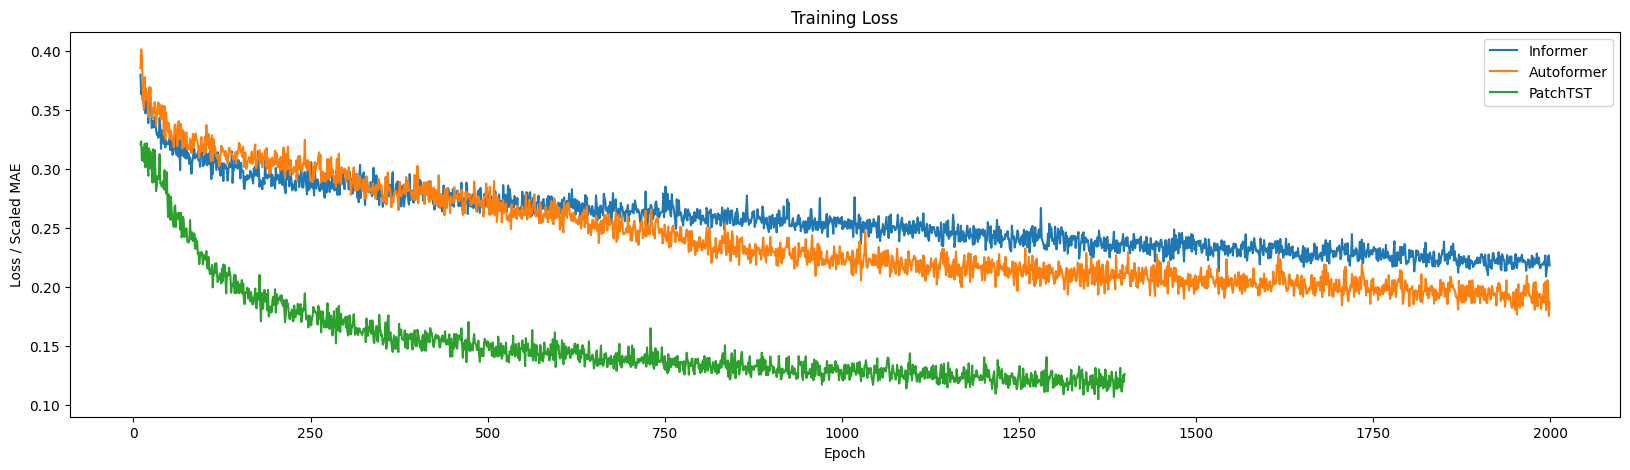

In [9]:
import matplotlib.pyplot as plt

# Creating DataFrames for easy plotting
# 去掉不稳定的前十个epoch
informer_loss = pd.DataFrame(nf.models[0].train_trajectories[10:], columns=['Epoch', 'Train Loss'])
autoformer_loss = pd.DataFrame(nf.models[1].train_trajectories[10:], columns=['Epoch', 'Train Loss'])
patchtst_loss = pd.DataFrame(nf.models[2].train_trajectories[10:], columns=['Epoch', 'Train Loss'])

# Plotting
plt.figure(figsize=(20,5))
plt.plot(informer_loss['Epoch'], informer_loss['Train Loss'], label='Informer')
plt.plot(autoformer_loss['Epoch'], autoformer_loss['Train Loss'], label='Autoformer')
plt.plot(patchtst_loss['Epoch'], patchtst_loss['Train Loss'], label='PatchTST')
plt.xlabel('Epoch')
plt.ylabel('Loss / Scaled MAE')
plt.title('Training Loss')
plt.legend()
plt.show()

In [10]:
df_pred = nf.predict(df_long, step_size=horizon, random_seed=42)
df_pred.head()

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

,ds,Informer,Autoformer,PatchTST
unique_id,,,,
global_entry,2024-02-01,7596.682617,11703.900391,7892.679688
global_entry,2024-02-02,7929.856934,11273.369141,8137.231445
global_entry,2024-02-03,7840.769043,9622.712891,8070.341309
global_entry,2024-02-04,6778.283203,9094.263672,8286.039062
global_entry,2024-02-05,6301.872070,9812.487305,8097.594238


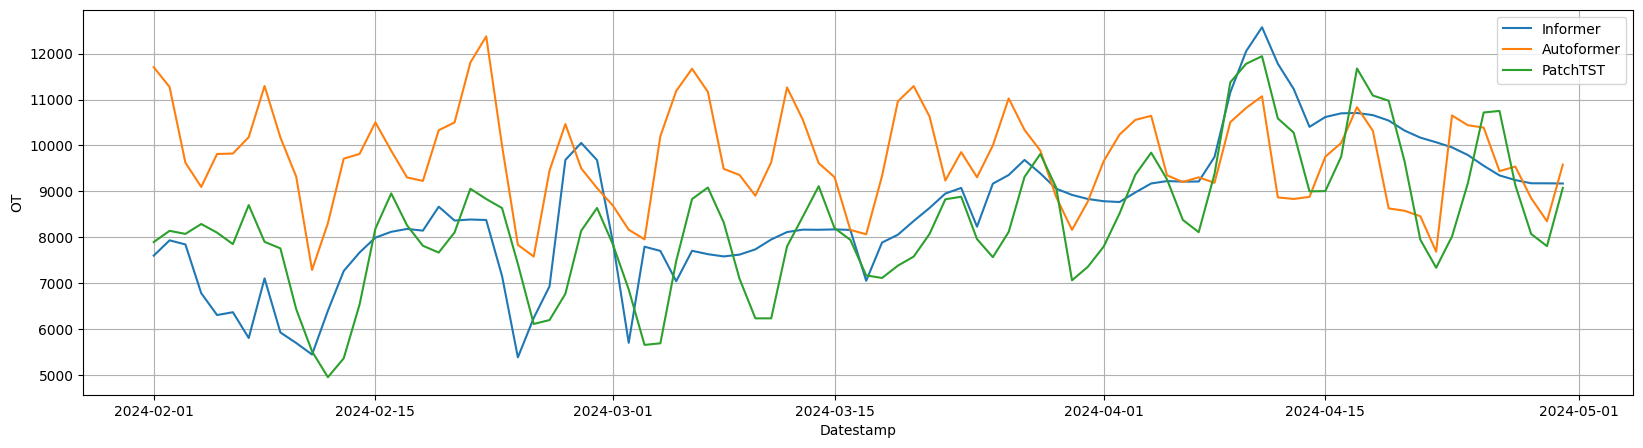

In [11]:
from matplotlib import pyplot as plt

Y_plot = df_pred[df_pred.index=='global_entry']

plt.figure(figsize=(20,5))
plt.plot(Y_plot['ds'], Y_plot['Informer'], label='Informer')
plt.plot(Y_plot['ds'], Y_plot['Autoformer'], label='Autoformer')
plt.plot(Y_plot['ds'], Y_plot['PatchTST'], label='PatchTST')
plt.xlabel('Datestamp')
plt.ylabel('OT')
plt.grid()
plt.legend()